In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# define the image transformations
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

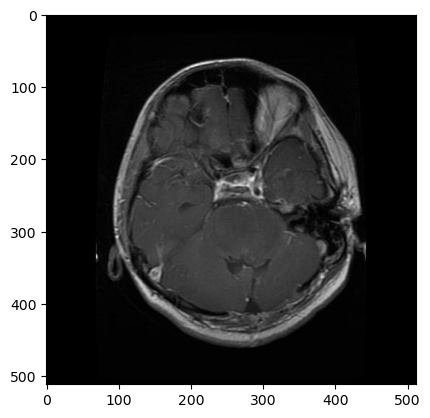

In [3]:
# load the image
img = Image.open(str('./data/original/Testing/glioma/Te-gl_0010.jpg'))
plt.imshow(img)
plt.show()

In [4]:
# load a pre-trained VGG16 model
pretrained_model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

# extract convolutional layers and respective weights
conv_weights = []
conv_layers = []
total_conv_layers = 0 # this is a counter

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/helenyxtian/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|████████████████████████████████████████| 548M/548M [01:09<00:00, 8.22MB/s]


In [5]:
# traverse through the model to extract convolutional layers and weights
for module in pretrained_model.features.children():
    if isinstance(module, nn.Conv2d):
        total_conv_layers += 1
        conv_weights.append(module.weight)
        conv_layers.append(module)
total_conv_layers

16

In [6]:
# move model to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model = pretrained_model.to(device)

# preprocess the image and move it to the gpu
img = img_transform(img)
img = img.unsqueeze(0)
img = img.to(device)

# extract feature maps
feature_maps = []
layer_names = []
for l in conv_layers:
    img = l(img)
    feature_maps.append(img)
    layer_names.append(str(l))

In [7]:
# display feature maps shapes
print("\nFeature maps shape")
for fm in feature_maps:
    print(fm.shape)

# process and visualize feature maps
processed_feature_maps = []
for fm in feature_maps:
    fm = fm.squeeze(0)
    mean_fm = torch.sum(fm, 0) / fm.shape[0]
    processed_feature_maps.append(mean_fm.data.cpu().numpy())

#size([1, 64, 224, 224]) means 64 images of size 224x224 have 1 channel (grayscale)


Feature maps shape
torch.Size([1, 64, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])


In [8]:
# display processed feature maps shapes
print("\nProcessed feature maps shape")
for fm in processed_feature_maps:
    print(fm.shape)    


Processed feature maps shape
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


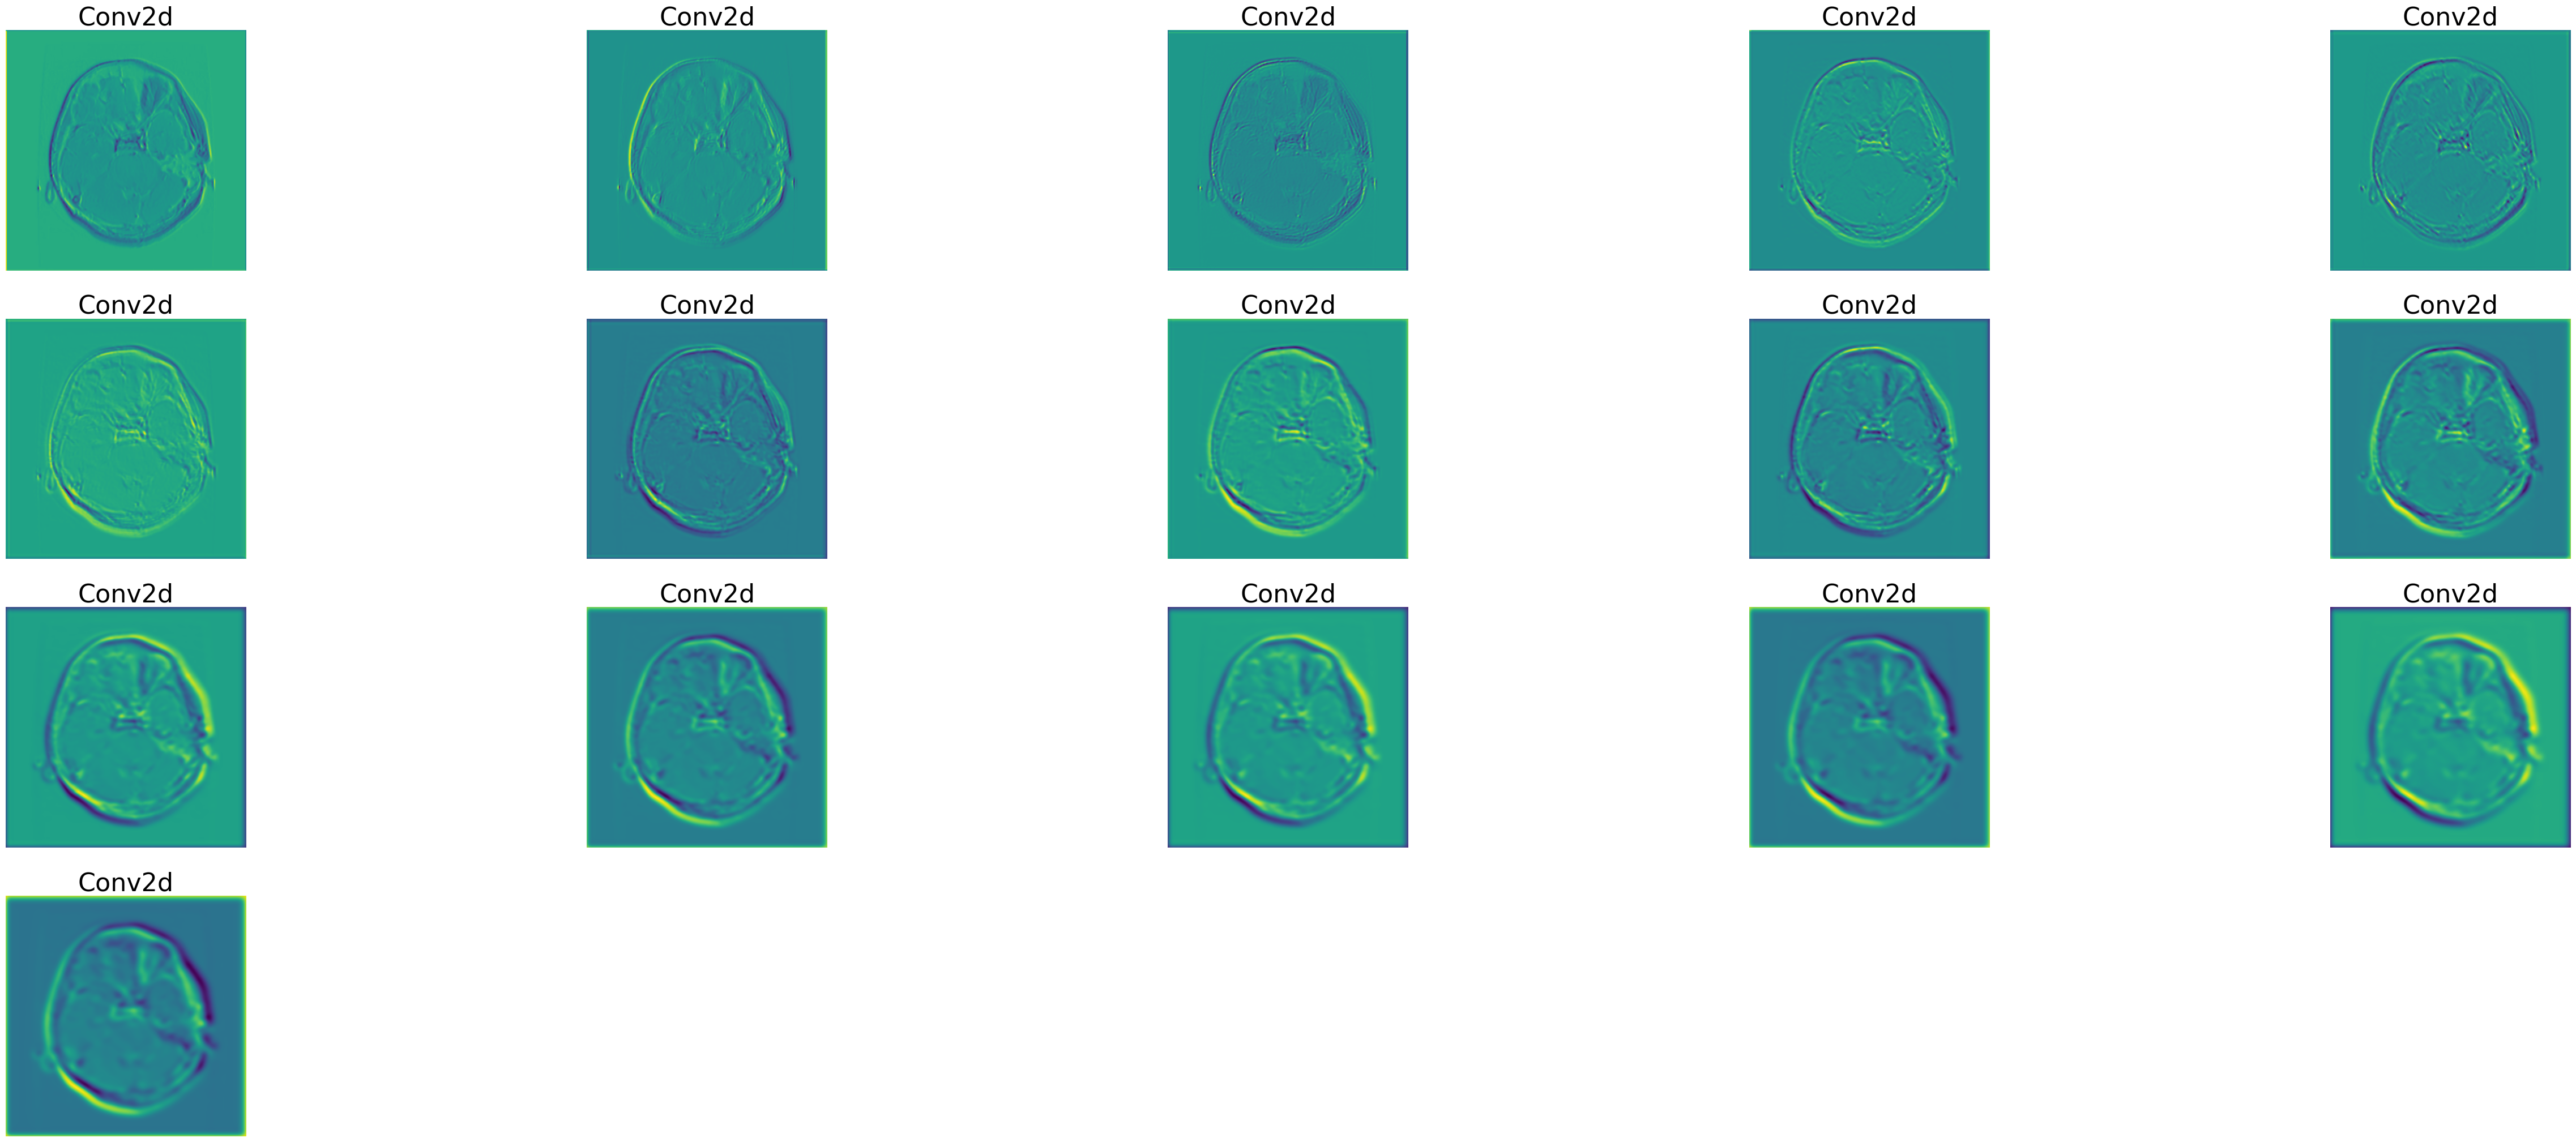

In [9]:
# plot the feature maps
fig = plt.figure(figsize=(64,32))
for i in range(len(processed_feature_maps)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(processed_feature_maps[i])
    ax.axis("off")
    ax.set_title(layer_names[i].split('(')[0], fontsize=32)

In [10]:
flattened_features = [fm.flatten() for fm in processed_feature_maps]
flattened_features

[array([0.26637244, 0.10080256, 0.10080256, ..., 0.22845758, 0.22845758,
        0.17157741], dtype=float32),
 array([ 0.12548664, -0.24117315, -0.01321942, ..., -0.42989066,
        -0.08581306, -0.07822963], dtype=float32),
 array([0.13173789, 0.6154635 , 0.6416546 , ..., 1.0996896 , 0.01751116,
        0.44065818], dtype=float32),
 array([ 4.976958 ,  4.254606 ,  1.7708338, ..., -4.777935 , -2.92133  ,
         2.549231 ], dtype=float32),
 array([ 0.28512484,  0.9337022 ,  2.5098095 , ...,  2.577716  ,
        -2.2983608 , -1.8918432 ], dtype=float32),
 array([12.312533, 16.834822, 21.463873, ..., -5.510948,  0.589728,
        14.681602], dtype=float32),
 array([30.409248, 55.467556, 44.352215, ..., 28.502703, 12.595834,
        16.283104], dtype=float32),
 array([  63.836777,   74.512314,   70.20265 , ..., -238.17868 ,
        -124.29349 ,   54.237625], dtype=float32),
 array([370.2685 , 587.63416, 679.87244, ..., 397.08936,  87.01666,
         61.14177], dtype=float32),
 array([-1

In [11]:
import numpy as np

# compute summary statistics for each feature map
feature_stats = []

for fm in feature_maps:
    fm_np = fm.detach().cpu().numpy()  # Move to CPU and convert to numpy
    stats = {
        "mean": np.mean(fm_np),
        "std": np.std(fm_np),
        "max": np.max(fm_np),
        "min": np.min(fm_np),
    }
    feature_stats.append(stats)

feature_stats

[{'mean': 0.14854732, 'std': 0.8722992, 'max': 11.666604, 'min': -9.192199},
 {'mean': -0.1991253, 'std': 3.258188, 'max': 51.329697, 'min': -42.759964},
 {'mean': 0.4694836, 'std': 7.882235, 'max': 113.132065, 'min': -133.67911},
 {'mean': -1.364229, 'std': 29.902632, 'max': 822.7118, 'min': -822.0752},
 {'mean': 6.5001836, 'std': 70.20647, 'max': 2163.6675, 'min': -2298.3428},
 {'mean': 4.1097684, 'std': 201.15475, 'max': 5767.5024, 'min': -5975.7417},
 {'mean': 90.00771, 'std': 657.6126, 'max': 16579.06, 'min': -14722.7705},
 {'mean': -317.76733, 'std': 2470.968, 'max': 93612.88, 'min': -68516.7},
 {'mean': 1358.6361, 'std': 6192.4414, 'max': 258775.86, 'min': -168614.12},
 {'mean': -8681.324, 'std': 20365.72, 'max': 391906.5, 'min': -445319.1},
 {'mean': 66263.17, 'std': 73289.914, 'max': 1704767.1, 'min': -1173526.5},
 {'mean': -595200.44, 'std': 308745.4, 'max': 4957301.0, 'min': -6824749.0},
 {'mean': 3631408.0, 'std': 1574058.1, 'max': 26693266.0, 'min': -12314357.0},
 {'mean':

In [12]:
activation_strengths = [torch.sum(torch.abs(fm)).item() for fm in feature_maps]
activation_strengths

[1819000.5,
 6701628.5,
 31478458.0,
 107891408.0,
 500115136.0,
 1491510912.0,
 4959142912.0,
 17185478656.0,
 96430555136.0,
 381792747520.0,
 2016456081408.0,
 15709575839744.0,
 93907933200384.0,
 694011685765120.0,
 5095960443092992.0,
 4.210835758619034e+16]